In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
"""
network.py
~~~~~~~~~~

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""
class Network():

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid_vec(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            np.random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if j % 10 == 0:
                if test_data:
                    print "Epoch {0}: {1} / {2}".format(
                        j, self.evaluate(test_data), n_test)
                else:
                    print "Epoch {0} complete".format(j)

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid_vec(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime_vec(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            spv = sigmoid_prime_vec(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * spv
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y) 
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
        
    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y) 

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

sigmoid_vec = np.vectorize(sigmoid)

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

sigmoid_prime_vec = np.vectorize(sigmoid_prime)

A Classification Example
------------------------

Lets look at a new classification problem using our neural network code.  For this example we will use another classic
machine learning data set known as the `iris` data set.  This data set consists of measurements of 3 types of iris, a
species of flowers.  4 separate measures (sepal length, sepal width, petal length, petal width) 
were made of 150 different flowers.  There are 50 different instances of the 3 different classes of flowers in the
data set.  The data set was
labeled with the correct species for each data item, 'iris-setosa', 'iris-versicolor' or 'iris-virginica'.  We would
like to build a neural network that will predict the class, or type of flower being examined given the 4 measurements
for a new unknown flower.  

First of all, lets load the data from a file and explore the data a bit.  We downloaded the data set from the
[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Iris).  Here I show an example of using
the `pandas` library to load the data set into a `pandas` `DataFrame` object.  The `pandas` library is a powerful
library for doing data analysis and statistics on scientific data sets.  Here we are using `pandas` to parse and load
the data file for us, and to do some preliminary exploration of the data.

In [3]:
d = pd.read_csv('data/iris.data', names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class_name'])
d.head()

sepal_length  sepal_width  petal_length  petal_width   class_name
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

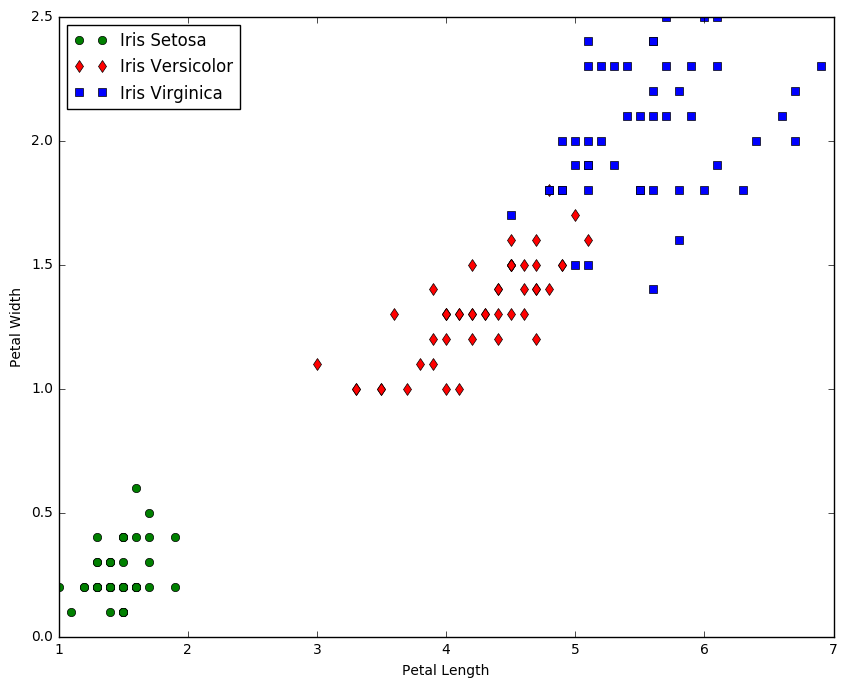

In [4]:
# plot the 3 separate classes
setosa = d[d.class_name == 'Iris-setosa']
versicolor = d[d.class_name == 'Iris-versicolor']
virginica = d[d.class_name == 'Iris-virginica']

plt.figure(figsize=(10, 8))
plt.plot(setosa.petal_length, setosa.petal_width, 'go', label='Iris Setosa')
plt.plot(versicolor.petal_length, versicolor.petal_width, 'rd', label='Iris Versicolor')
plt.plot(virginica.petal_length, virginica.petal_width, 'bs', label='Iris Virginica')
plt.legend(loc=0)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')

Here we only plot 2 of the 4 measurements against one another.  Notice that using these 2 measures, we can easily see that the
Setosa species is clearly separated from the other two species classes (it has smaller petal lengths and widths.  The 
Versicolor and Virginica species have more overlap with one another, but are generally separated as well using these 2
measures, with the Versicolor petals being of more medium length and width than the Virginica species, which in general has
the largest petals as measured by their length and width.

We would like to train a neural network to learn to predict the flower class given the 4 measurements.  Thus we need a network
with 4 units of input.  As with the digit classification task for the MNIST data, we would like the network to classify each
input as one of 3 possible classes for the output.  As with the MNIST digits, we will convert the targets into a 1-of-N encoding
though in this datasets case, there are only 3 classes as possible outputs.  Thus, we need to create target outputs like
`[1 0 0]` to represent the Setosa class, `[0 1 0]` for the Versicolor class, and `[0 0 1]` for the Virginica class.  Thus our
network will have 4 inputs and 3 outpus, and a hidden layer of some number of units (yet to be determined).

You can look in the `iris.names` file to get more information about this data set.  For example, the min, max and average
values for our 4 features are:

In [5]:
d.describe()

sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

In order to use these 4 features as input to our network, we need to normalize the values.  Since we will be usinng sigmoidal 
units, we can normalize our inputs to be values between -1 and 1.  This type of normalization is necessary and commonly done
for neural networks.  In our case, to map the values to the desired range, we need to subtract the minimum value from each
feature, so that we shift the values to range from 0 to some maximum.  Then we divide by this new maximum, so that our values now
range from 0 to 1.  Then we can multiple by 2 and subtract 1 to again shift the values to be in the range from -1 to 1.

For example, to map the Sepal Length values to the desired range, we can do the previously described steps like this:

In [6]:
# subtract the minimum value for this feature from all measurements, result now ranges from 0 to max-min
sl1 = d.sepal_length - d.sepal_length.min()

# now divide by the new max, thus mapping to range 0 to 1
sl2 = sl1 / sl1.max()

# now remap into range -1 to 1
sl3 = 2.0 * sl2 - 1.0

print sl3
print sl3.min(), sl3.max()

0     -5.555556e-01
1     -6.666667e-01
2     -7.777778e-01
3     -8.333333e-01
4     -6.111111e-01
5     -3.888889e-01
6     -8.333333e-01
7     -6.111111e-01
8     -9.444444e-01
9     -6.666667e-01
10    -3.888889e-01
11    -7.222222e-01
12    -7.222222e-01
13    -1.000000e+00
14    -1.666667e-01
15    -2.222222e-01
16    -3.888889e-01
17    -5.555556e-01
18    -2.222222e-01
19    -5.555556e-01
20    -3.888889e-01
21    -5.555556e-01
22    -8.333333e-01
23    -5.555556e-01
24    -7.222222e-01
25    -6.111111e-01
26    -6.111111e-01
27    -5.000000e-01
28    -5.000000e-01
29    -7.777778e-01
           ...     
120    4.444444e-01
121   -2.777778e-01
122    8.888889e-01
123    1.111111e-01
124    3.333333e-01
125    6.111111e-01
126    5.555556e-02
127   -2.220446e-16
128    1.666667e-01
129    6.111111e-01
130    7.222222e-01
131    1.000000e+00
132    1.666667e-01
133    1.111111e-01
134   -2.220446e-16
135    8.888889e-01
136    1.111111e-01
137    1.666667e-01
138   -5.555556e-02


We can actually do all of the preceeding for all features using `NumPy` array operations.  For example, we can do the steps
like this to our original `d` `DataFrame`, by transforming the `DataFrame` to a NumPy array:

In [7]:
# get only the input features and convert to a numpy array for processing
n = d[ ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'] ].as_matrix()
# subtract minimum from each column/feature
n = n - n.min(axis=0)
# divide by the new maximum for each column/feature, to put into range 0 to 1
n = n / n.max(axis=0)
# now remap to -1 to 1
n = 2.0 * n - 1.0
print n.max(axis=0), n.min(axis=0), n.shape

inputs = n

[ 1.  1.  1.  1.] [-1. -1. -1. -1.] (150, 4)


Now we also need to create our target output arrays for the inputs.  Recall that we would like to have a (150,3) shapped output
array, with a 1 in the appropriate column to represent the output class.  We can use the original `d` `DataFrame` with the
`class_name` column to perform this task:

In [8]:
outputs = np.zeros( (150, 3) )
for i, class_name in enumerate(d.class_name):
    if class_name == 'Iris-setosa':
        class_type = 0
    if class_name == 'Iris-versicolor':
        class_type = 1
    if class_name == 'Iris-virginica':
        class_type = 2
    outputs[i, class_type] = 1.0

We now have the 4 features in our `inputs` `NumPy` array, and we have a corresponding set of labeled target `outputs` that can
be used to train a network with three output units.  We need to once again divide up the data into training, testing
and validation data, and format tupples appropriately for our network `SGD` training function.  As we have done before, we
can do this ourself by hand using Python array slicing.  So for example, to divide the data into 50% for the training
set, and the rest evenly split between a validation and test set, we could do this:

In [9]:
train_input = inputs[0::2]
test_input = inputs[1::4]
valid_input = inputs[3::4]

train_target = outputs[0::2]
test_target = np.argmax(outputs[1::4], axis=1) # because for testing and validation, we need to pass in the class label instead
valid_target = np.argmax(outputs[3::4], axis=1)

train_data = [(input.reshape(4,1), target.reshape(3,1)) for input, target in zip(train_input, train_target)]
test_data = [(input.reshape(4,1), target.reshape(1,1)) for input, target in zip(test_input, test_target)]
valid_data = [(input.reshape(4,1), target.reshape(1,1)) for input, target in zip(valid_input, valid_target)]

In [10]:
# train a network with 5 hidden units
net = Network( (4, 20, 3) )
net.SGD(train_data, 1000, 5, 0.1, test_data=valid_data)

Epoch 0: 13 / 37
Epoch 10: 13 / 37
Epoch 20: 34 / 37
Epoch 30: 33 / 37
Epoch 40: 34 / 37
Epoch 50: 35 / 37
Epoch 60: 36 / 37
Epoch 70: 36 / 37
Epoch 80: 36 / 37
Epoch 90: 36 / 37
Epoch 100: 36 / 37
Epoch 110: 36 / 37
Epoch 120: 36 / 37
Epoch 130: 36 / 37
Epoch 140: 36 / 37
Epoch 150: 36 / 37
Epoch 160: 36 / 37
Epoch 170: 36 / 37
Epoch 180: 36 / 37
Epoch 190: 36 / 37
Epoch 200: 36 / 37
Epoch 210: 36 / 37
Epoch 220: 36 / 37
Epoch 230: 36 / 37
Epoch 240: 36 / 37
Epoch 250: 36 / 37
Epoch 260: 36 / 37
Epoch 270: 36 / 37
Epoch 280: 36 / 37
Epoch 290: 36 / 37
Epoch 300: 36 / 37
Epoch 310: 36 / 37
Epoch 320: 36 / 37
Epoch 330: 36 / 37
Epoch 340: 36 / 37
Epoch 350: 36 / 37
Epoch 360: 36 / 37
Epoch 370: 35 / 37
Epoch 380: 35 / 37
Epoch 390: 35 / 37
Epoch 400: 35 / 37
Epoch 410: 35 / 37
Epoch 420: 35 / 37
Epoch 430: 35 / 37
Epoch 440: 35 / 37
Epoch 450: 35 / 37
Epoch 460: 35 / 37
Epoch 470: 35 / 37
Epoch 480: 35 / 37
Epoch 490: 35 / 37
Epoch 500: 35 / 37
Epoch 510: 36 / 37
Epoch 520: 35 / 37
Epoc

In [11]:
def confusion_matrix(net, test_data):
    """Given a trained network, determine confusion matrix for a set of inputs with
    the given correct targets.  This function assumes 3 classes labeled 0, 1 and 2"""
    conf_matrix = np.zeros( (3, 3) )
    test_results = [ (np.argmax(net.feedforward(x)), y[0][0]) for (x, y) in test_data ]   
    for (output, target) in test_results:
        conf_matrix[target, output] += 1.0
    return conf_matrix

print confusion_matrix(net, valid_data)
print confusion_matrix(net, test_data)

[[ 12.   0.   0.]
 [  0.  12.   1.]
 [  0.   0.  12.]]
[[ 13.   0.   0.]
 [  0.  12.   0.]
 [  0.   1.  12.]]
